In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn import model_selection
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from scipy.stats import pearsonr as psr
from scipy.sparse import csr_matrix

# Data Setup and Analysis

In [109]:
# Reading rating file
ratings = pd.read_csv('Data/BX-Book-Ratings.csv', sep=';', encoding='latin-1')

# Reading users file
users = pd.read_csv('Data/BX-Users.csv', sep=';', encoding='latin-1')

# Reading books file
books = pd.read_csv('Data/BX-Books.csv',  sep=';', encoding='latin-1')

In [3]:
n_users = users['User-ID'].size
n_ratings = ratings['User-ID'].size
print('Number of users:', n_users)
print('Number of ratings', n_ratings)

Number of users: 278858
Number of ratings 1149780


max number of rating for user: 13602


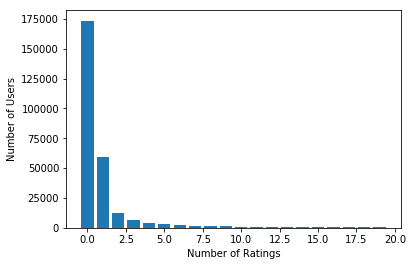

In [4]:
# Data repartition (number of ratings per user)

user_count = {}
ratings_count = np.zeros(11)
maximum = 0
ID = -1

for i in range(0,n_users):
    user_count[i+1] = 0

for element in ratings.values:
    user, ISBN, rating = element
    user_count[user]+=1
    ratings_count[rating]+=1
    if user_count[user]>maximum:
        maximum = user_count[user]
        ID = user

print('max number of rating for user:',maximum)
# Plotting 
num = np.zeros(maximum+1)
for i in user_count:
    num[user_count[i]]+=1
    
plt.bar(range(0,20),num[0:20])
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

In [5]:
# Get the number of users with n ratings or more
n = 5

cc = 0
k = 0
for i in num:
    if k>=n:
        cc += int(i)
    k+=1
print('Number of users with 5 ratings or more:',cc)

Number of users with 5 ratings or more: 22816


Most users only have 0 or 1 rating

=> We chose to train and evaluate the model on users with more than 5 ratings

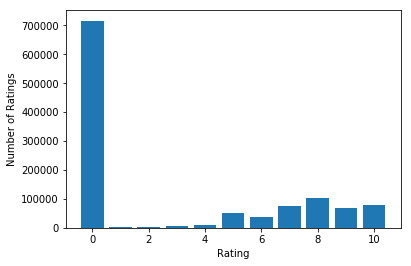

In [6]:
# rating repartition

plt.bar(range(11),ratings_count)
plt.ylabel('Number of Ratings')
plt.xlabel('Rating')
plt.show()

0 ratings dominant and seem unrealistic

=> delete all the 0 ratings

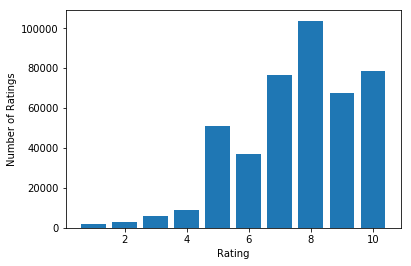

In [7]:
# rating repartition

plt.bar(range(1,11),ratings_count[1:])
plt.ylabel('Number of Ratings')
plt.xlabel('Rating')
plt.show()

# Data Clearing

In [8]:
# Parameters
min_val = 5
min_ratings = 5

In [9]:
# Initialisation
cleaned_data = ratings.copy()
cleaned_users = users.copy()
cleaned_books = books.copy()

In [10]:
# Delete all 0 ratings
cleaned_data = cleaned_data[ cleaned_data['Book-Rating']>0]

# Delete books with less than min_ratings ratings
ratings_per_book =  cleaned_data['ISBN'].value_counts()
cleaned_data = cleaned_data[cleaned_data['ISBN'].isin(ratings_per_book.index[ratings_per_book.values >= min_val])]

In [11]:
# Number of ratings per user
ratings_per_user = cleaned_data['User-ID'].value_counts()
ratings_per_book = cleaned_data['ISBN'].value_counts()

In [12]:
# Select data from users with more than min_val ratings
cleaned_data = cleaned_data[cleaned_data['User-ID'].isin(ratings_per_user.index[ratings_per_user.values >= min_val])]

# Get the selected users
cleaned_users = sorted(cleaned_data['User-ID'].unique())

In [13]:
# Create the pivot table
table = pd.pivot_table(cleaned_data, values='Book-Rating', index='User-ID', columns='ISBN')

In [14]:
# Create train and test set
X_train, X_test = model_selection.train_test_split(table, test_size=0.25, random_state=42)

In [15]:
# Get the users average rating
means = {}
idx = table.index
for i in idx:
    means[i] = np.nanmean(table[table.index==i])

In [16]:
# Get the books average rating
ISBN_means = {}
ISBN_list = table.columns
for i in ISBN_list:
    ISBN_means[i] = np.nanmean(table[i].values)

# User - User

In [154]:
class User_User_prediction():
    def __init__(self, books, table, means):
        self.books = books
        self.means = means
        self.table = table
        
        table_test = table.copy()
        table_test = table_test.replace(np.NaN, 0.)
        self.sparse = csr_matrix(table_test.values)
        print('Predictor has been set up')
        
        
    def predict(self, user, k=-1):
        """
        Predict the user's score on the books
        """
        prediction = np.zeros(len(self.table.columns.values))
        prediction.fill(means[user])
        mask = np.isnan(self.table[table.index == user]) # mask to remove the already present values
        sel = 0
        sim_dic = {}
        user_t = self.sparse[list(self.table.index).index(user)].nonzero()[1]

        # Calculate the corelation between all users and the curent user
        for user2 in table.index:
            user2_t = self.sparse[list(self.table.index).index(user2)].nonzero()[1]
            sim_dic[user2] = self.sim(user_t, user2_t, user, user2)
        
        # for each book
        for i in range(len(table.columns)):
            # find all the users that have rated the book
            user_sel = self.table[self.table[self.table.columns[i]].isnull() == False].index
            sel = 0
            too = 0
            ok = False
            
            # predict the current user's score based on the pearsons correlation
            for user2 in user_sel:
                to_add = sim_dic[user2] * (self.table[self.table.index == user2].values[0][i] - self.means[user2])
                if np.isnan(to_add)==False:
                    too += to_add
                    sel += abs(sim_dic[user2])
                    ok = True
            too = too/(sel+10**-10)     
            prediction[i] += too        
        return prediction*mask

    
    def sim(self, user1_t, user2_t, user1, user2):
        """
        Calculate the pearsons correlation between 2 users
        """
        top = 0
        bot1 = 0
        bot2 = 0
        table1 = self.table[self.table.index == user1].values[0]
        table2 = self.table[self.table.index == user2].values[0]
        mean1 = np.nanmean(table1)
        mean2 = np.nanmean(table2)
        
        common = list(set(user1_t)-(set(user1_t)-set(user2_t)))
        for i in common:
            top += (table1[i]-mean1)*(table2[i]-mean2)
            bot1 += (table1[i]-mean1)**2
            bot2 += (table2[i]-mean2)**2       
        if bot1 != 0 and bot2 != 0:
            return top/(np.sqrt(bot1)*np.sqrt(bot2))
        else:
            return np.NaN

    
    def find_closest(self, dic, k=-1):
        """
        Sorts the dictionnary and return the k biggest value, if k = -1, returns the dictionnary unsorted
        """
        if k==-1:
            return dic
        else:
            sorted_dic = sorted(dic.items(), key = lambda sd:(sd[1], sd[0]), reverse = True)
            return sorted_dic[:k]
        
          
    def get_max(self, prediction):
        """
        gets the book titles for the books with maximal prediction
        """
        max_val = np.argmax(prediction)
        book = self.books[self.books['ISBN'] == prediction[max_val]]
        
    
    def process(self, user, k=-1, n=5):
        """
        Predicts the books with the highest probable ratings for the user
        """
        prediction = self.predict(user, k).values[0]
        return prediction
        idx = np.argpartition(prediction, -n)[-n:]
        idx = idx[np.argsort(prediction[idx])]
        best = self.table.columns[idx]
        return best

We can now pick a random user and predict his scores !

In [155]:
Predictor = User_User_prediction(books, table, means)
user = random.choice(table.index)
print("user "+str(user)+" will be predicted")
interesting_books = Predictor.process(user)
print("intersting books ISBN for " + str(user) +":", interesting_books)

Predictor has been set up
user 245568 will be predicted
intersting books ISBN for245568: [5.46059313 6.46059313 6.94444444 ... 6.94444444 6.94444444 6.18834688]
